In [1]:
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keraspp import skeras, sfile

Using TensorFlow backend.


In [2]:
class CNN(Model):
    def __init__(self, nb_classes, in_shape=None):
        super().__init__()
        self.nb_classes = nb_classes
        self.in_shape = in_shape
        self.build_model()
        super().__init__(self.x, self.y)
        self.compile()
    
    def build_model(self):
        nb_classes = self.nb_classes
        in_shape = self.in_shape
        
        x = Input(in_shape)
        h = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape)(x)
        h = Conv2D(32, kernel_size=(3, 3), activation='relu')(h)
        h = MaxPooling2D(pool_size=(2, 2))(h)
        h = Dropout(0.25)(h)
        h = Flatten()(h)
        z_cl = h
        
        h = Dense(128, activation='relu')(h)
        h = Dropout(0.5)(h)
        z_fl =h
        
        y = Dense(nb_classes, activation='softmax', name='preds')(h)
        
        cl_part = Model(x, z_cl)
        fl_part = Model(x, z_fl)
        self.cl_part, self.fl_part = cl_part, fl_part
        self.x, self.y = x, y
        


    def compile(self):
        Model.compile(self, loss='categorical_crossentropy',
                      optimizer='adadelta', metrics=['accuracy'])

In [3]:
class DataSet:
    def __init__(self, X, y, nb_classes, scaling=True, test_size=0.2, random_state = 0):
        '''
        X is originally vector. 
        '''
        self.X = X
        self.add_channels()

        X = self.X

        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=random_state)
        print(X_train.shape, y_train.shape)

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        if scaling:
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train = scaler.fit_transform(X_train.reshape(n, -1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test = scaler.transform(X_test.reshape(n, -1)).reshape(X_test.shape)
            self.scaler = scaler

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_test.shape[0], 'test samples')

        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test

    def add_channels(self):
        X = self.X
        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape
            if K.image_dim_ordering() == 'th':
                X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:]
        
        self.X = X
        self.input_shape = input_shape


In [4]:
class Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y)
        self.set_model()
        self.fig = fig
    
    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = DataSet(X, y, nb_classes)
        print('data.input_shape', self.data.input_shape)
    
    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes=nb_classes, in_shape=data.input_shape)
        
    def fit(self, epochs=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        
        history = model.fit(data.X_train, data.Y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(data.X_test, data.Y_test))
        return history
    
    def run(self, epochs=100, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        fig = self.fig
        
        history = self.fit(epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        score = model.evaluate(data.X_test, data.Y_test, verbose=0)
        
        print('Confusion matrix')
        Y_test_pred = model.predict(data.X_test, verbose=0)
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))
        
        print('Test score:', score[0])
        print('Test accuracy:', score[1])
        
        suffix = sfile.unique_filename('datetime')
        foldname = 'output_' + suffix
        os.makedirs(foldname)
        skeras.save_history_history('history_history.npy', history.history, fold=foldname)
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output results are saved in', foldname)
        
        if fig:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            skeras.plot_acc(history)
            plt.subplot(1, 2, 2)
            skeras.plot_loss(history)
            plt.show()

        self.history = history
        
        return foldname

In [5]:
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'

from keraspp import aicnn

class CifarMachine(Machine):
    def __init__(self):
        (X, y), (x_test, y_test) = datasets.cifar10.load_data()
        super().__init__(X, y, nb_classes=10)
        
def main():
    m = CifarMachine()
    m.run()
    

(40000, 32, 32, 3) (40000, 1)
X_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
data.input_shape (32, 32, 3)
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 7s 166us/step - loss: 1.8727 - accuracy: 0.3254 - val_loss: 1.4502 - val_accuracy: 0.4925
Epoch 2/100
40000/40000 [==============================] - 6s 142us/step - loss: 1.4435 - accuracy: 0.4890 - val_loss: 1.3737 - val_accuracy: 0.5007
Epoch 3/100
40000/40000 [==============================] - 6s 143us/step - loss: 1.2711 - accuracy: 0.5509 - val_loss: 1.1145 - val_accuracy: 0.6031
Epoch 4/100
40000/40000 [==============================] - 6s 146us/step - loss: 1.1646 - accuracy: 0.5907 - val_loss: 1.0544 - val_accuracy: 0.6320
Epoch 5/100
40000/40000 [==============================] - 6s 141us/step - loss: 1.0811 - accuracy: 0.6191 - val_loss: 1.0176 - val_accuracy: 0.6388
Epoch 6/100
40000/40000 [==============================] - 6s 142us/step 

40000/40000 [==============================] - 6s 142us/step - loss: 0.4220 - accuracy: 0.8541 - val_loss: 1.2655 - val_accuracy: 0.7136
Epoch 55/100
40000/40000 [==============================] - 6s 146us/step - loss: 0.4205 - accuracy: 0.8544 - val_loss: 1.4295 - val_accuracy: 0.7145
Epoch 56/100
40000/40000 [==============================] - 6s 145us/step - loss: 0.4221 - accuracy: 0.8532 - val_loss: 1.1272 - val_accuracy: 0.7140
Epoch 57/100
40000/40000 [==============================] - 6s 142us/step - loss: 0.4178 - accuracy: 0.8574 - val_loss: 1.0333 - val_accuracy: 0.7024
Epoch 58/100
40000/40000 [==============================] - 6s 146us/step - loss: 0.4209 - accuracy: 0.8549 - val_loss: 1.0880 - val_accuracy: 0.7095
Epoch 59/100
40000/40000 [==============================] - 6s 141us/step - loss: 0.4281 - accuracy: 0.8554 - val_loss: 1.1510 - val_accuracy: 0.7160
Epoch 60/100
40000/40000 [==============================] - 6s 140us/step - loss: 0.4250 - accuracy: 0.8543 - val

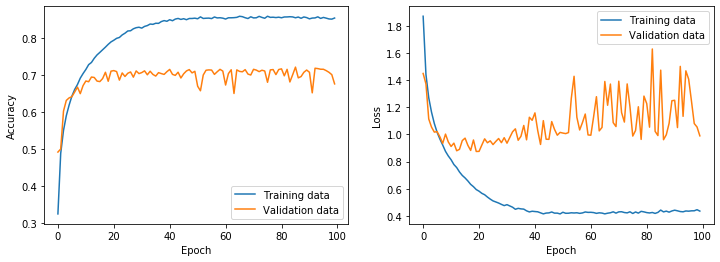

In [6]:
main()